In [1]:
import sys
import json
import numpy as np
import tensorflow as tf
import help_functions as hf
from matplotlib import pyplot as plt

### What is the correlation between the label frequency in the dataset, its optimal threshold based on the f1-score, and its f1-score?

In [2]:
i = 0
with open('training_configurations.json', 'r') as fp:
    config = json.load(fp)[str(i)]

In [3]:
# Get label frequency in dataset
train = hf.get_flow(df_file=config['data_folder'] + '/train_df.json.bz2',
                    nr_classes=config['nr_classes'],
                    image_dimension=config['image_dimension'])
y_true = hf.get_y_true(shape=(train.samples, len(train.class_indices)), classes=train.classes)
label_frequencies = y_true.sum(axis=0) / y_true.sum()

Found 760000 non-validated image filenames belonging to 42 classes.


/home/matvieir/wiki_image_classification/src/classification/help_functions.py:220: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_x_labels['labels'] = df['labels'].apply(lambda labels_list: [label for label in labels_list if label in top_classes])
/home/matvieir/anaconda3/lib/python3.8/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 1 invalid image filename(s) in x_col="url". These filename(s) will be ignored.
  warnings.warn(


Found 752497 validated image filenames belonging to 20 classes.



Number of layers in basemodel: 339
Number of trainable layers: 0

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb2 (Functional)  (None, 2, 2, 1408)        7768569   
_________________________________________________________________
flatten_1 (Flatten)          (None, 5632)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               721024    
_________________________________________________________________
dense_3 (Dense)              (None, 20)                2580      
Total params: 8,492,173
Trainable params: 723,604
Non-trainable params: 7,768,569
_________________________________________________________________
Found 50000 non-validated image filenames belonging to 40 classes.


/home/matvieir/wiki_image_classification/src/classification/help_functions.py:220: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_x_labels = df[ids_x_labels]


Found 49514 validated image filenames belonging to 20 classes.
1548/1548 - 95s


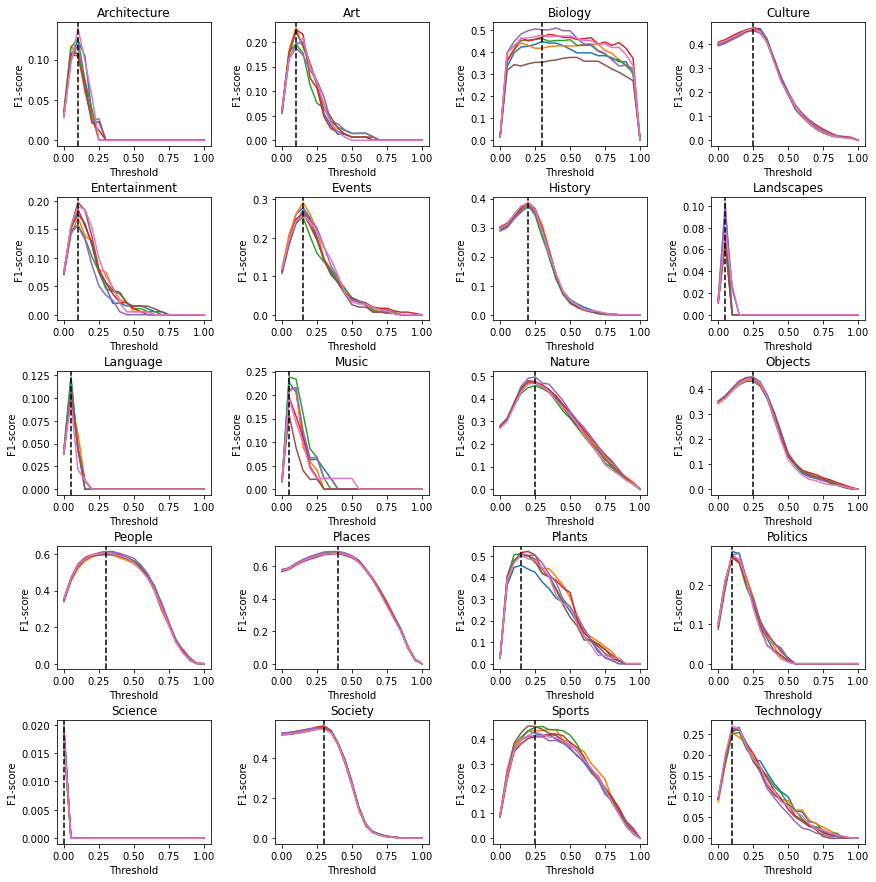

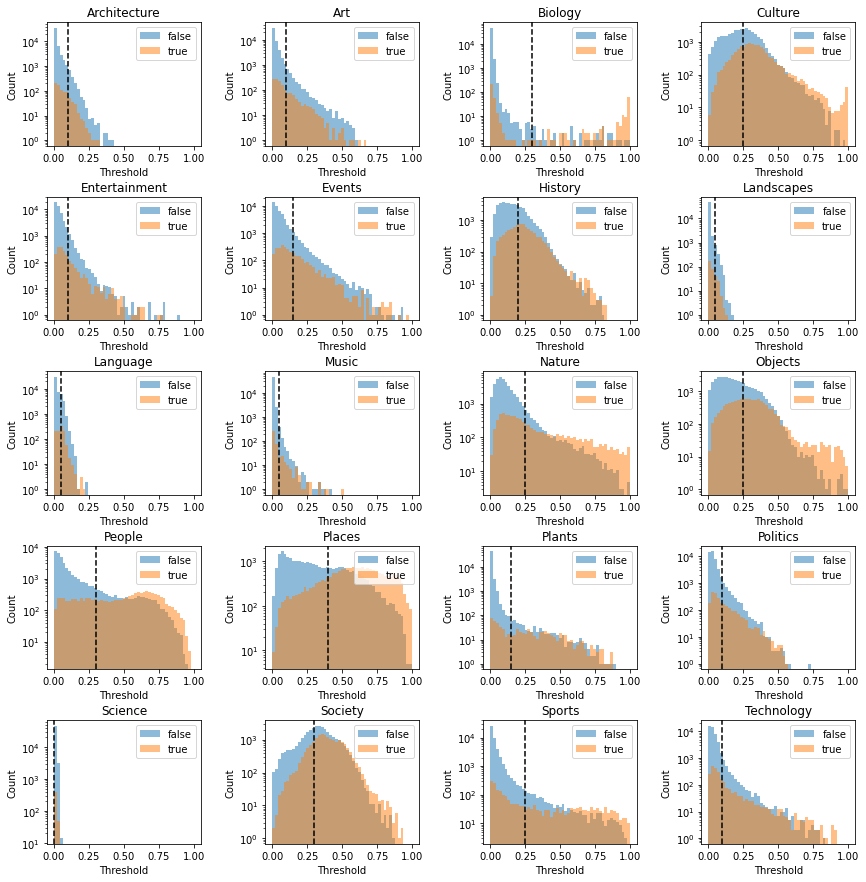

In [205]:
# Get optimal per-class thresholds based on f1-score on val_threshold set
model = hf.create_model(n_labels=config['nr_classes'], image_dimension=config['image_dimension'], model_name=config['basemodel'], number_trainable_layers=config['number_trainable_layers'])
latest = tf.train.latest_checkpoint(config['results_folder'] + '/checkpoints')
model.load_weights(latest)

val_threshold = hf.get_flow(df_file=config['data_folder'] + '/val_threshold_df.json.bz2',
                            nr_classes=config['nr_classes'],
                            image_dimension=config['image_dimension'])

probs_val = model.predict(val_threshold, verbose=2)
y_true_val = hf.get_y_true(shape=probs_val.shape, classes=val_threshold.classes)
optim_thresholds = hf.get_optimal_threshold(y_true=y_true_val, 
                                            probs=probs_val, 
                                            thresholds=np.linspace(start=0, stop=1, num=21), 
                                            labels=list(val_threshold.class_indices.keys()), 
                                            N=7,
                                            image_path=config['results_folder'])

In [5]:
# Per-class f1-score on the test set
# Load test set
test = hf.get_flow(df_file=config['data_folder'] + '/test_df.json.bz2',
                   nr_classes=config['nr_classes'],
                   image_dimension=config['image_dimension'])
# Predict on test set
print('Predicting on test set:\n')
probs_test = model.predict(test, verbose=2)
y_true_test = hf.get_y_true(shape=(test.samples, len(test.class_indices)), 
                            classes=test.classes)
y_pred_test_per_class_threshold = 1 * (probs_test > optim_thresholds)

Found 50000 non-validated image filenames belonging to 40 classes.


/home/matvieir/wiki_image_classification/src/classification/help_functions.py:220: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_x_labels['labels'] = df['labels'].apply(lambda labels_list: [label for label in labels_list if label in top_classes])


Found 49514 validated image filenames belonging to 20 classes.
Predicting on test set:

1548/1548 - 95s


In [13]:
f1_scores = hf.get_metrics(y_true_test, 
                           y_pred_test_per_class_threshold, 
                           label_names=list(test.class_indices.keys()), 
                           image_path='')


Mean number of label assignments per image in ground-truth: 2.1286
Mean number of label assignments per image in predictions: 4.6407

               precision    recall  f1-score   support index
Architecture    0.089552  0.199017  0.123523     814.0     0
Art             0.155340  0.309540  0.206866    1499.0     1
Biology         0.760234  0.305882  0.436242     425.0     2
Culture         0.340893  0.718905  0.462484   12462.0     3
Entertainment   0.142574  0.266385  0.185738    1892.0     4
Events          0.210616  0.366174  0.267418    3045.0     5
History         0.282346  0.594883  0.382939    8716.0     6
Landscapes      0.061688  0.174847  0.091200     326.0     7
Language        0.062348  0.479439  0.110346    1070.0     8
Music           0.172222  0.216783  0.191950     429.0     9
Nature          0.492090  0.450447  0.470348    7941.0    10
Objects         0.351115  0.598406  0.442559   10416.0    11
People          0.531055  0.700134  0.603985   10478.0    12
Places     

### Answer: see the plots below

##### Label-frequency vs f1-score

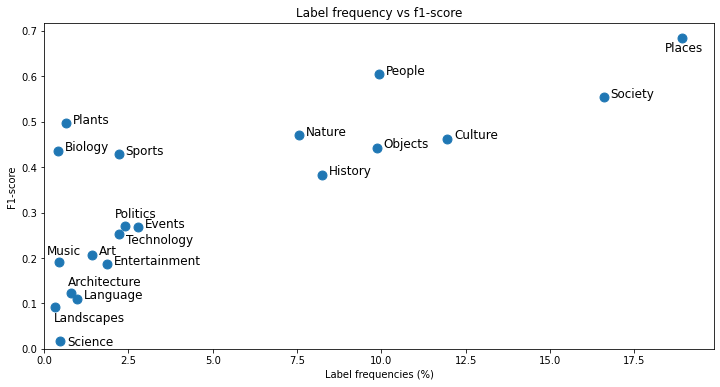

In [170]:
x_axis = label_frequencies * 100
y_axis = f1_scores.values
label_names = list(test.class_indices.keys())
plt.figure(figsize=(12, 6))
plt.scatter(x_axis, y_axis, s=80)
plt.xlabel('Label frequencies (%)')
plt.ylabel('F1-score')
plt.title('Label frequency vs f1-score')
plt.xlim([0, 1.05 * np.max(x_axis)])
plt.ylim([0, 1.05 * np.max(y_axis)])
# for i, txt in enumerate(label_names):
def annotate(i, fontsize, x_offset, y_offset, rotation=0):
    plt.annotate(label_names[i], 
                 (x_axis[i]+x_offset, y_axis[i]+y_offset), 
                 fontsize=fontsize, rotation=rotation)
x_offset = 0.2
annotate(0, 12, -0.1, 0.015)
annotate(1, 12, x_offset, 0)
annotate(2, 12, x_offset, 0)
annotate(3, 12, x_offset, 0)
annotate(4, 12, x_offset, 0)
annotate(5, 12, x_offset, 0)
annotate(6, 12, x_offset, 0)
annotate(7, 12, -0.02, -0.03)
annotate(8, 12, x_offset, 0)
annotate(9, 12, -0.35, 0.015)
annotate(10, 12, x_offset, 0)
annotate(11, 12, x_offset, 0)
annotate(12, 12, x_offset, 0)
annotate(13, 12, -0.5, -0.03)
annotate(14, 12, x_offset, 0)
annotate(15, 12, -0.3, 0.02)
annotate(16, 12, 0.2, -0.01)
annotate(17, 12, x_offset, 0)
annotate(18, 12, x_offset, 0)
annotate(19, 12, x_offset, -0.02)

##### Label-frequency vs optimal threshold

In [158]:
optim_thresholds

array([0.1 , 0.1 , 0.3 , 0.25, 0.1 , 0.15, 0.2 , 0.05, 0.05, 0.05, 0.25,
       0.25, 0.3 , 0.35, 0.15, 0.1 , 0.  , 0.3 , 0.25, 0.15])

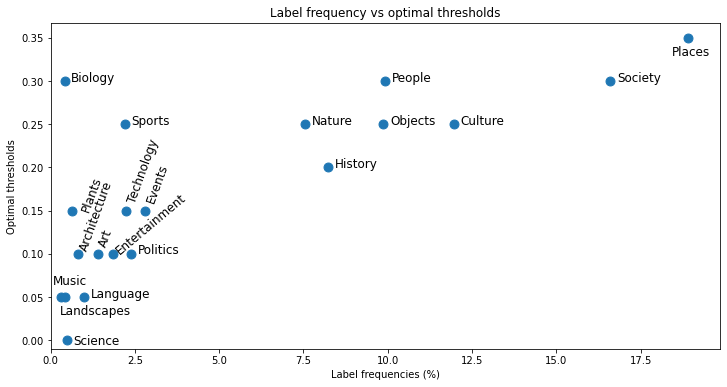

In [204]:
x_axis = label_frequencies * 100
y_axis = optim_thresholds
label_names = list(test.class_indices.keys())
plt.figure(figsize=(12, 6))
plt.scatter(x_axis, y_axis, s=80)
plt.xlabel('Label frequencies (%)')
plt.ylabel('Optimal thresholds')
plt.title('Label frequency vs optimal thresholds')
plt.xlim([0, 1.05 * np.max(x_axis)])
plt.ylim([-0.01, 1.05 * np.max(y_axis)])
annotate(0, 12, 0, 0.005, rotation=70) # architecture
annotate(1, 12, -0.05, 0.01, 70) # art
annotate(2, 12, x_offset, 0) # biology
annotate(3, 12, x_offset, 0) # culture
annotate(4, 12, 0, 0, 40) # entertainment
annotate(5, 12, 0, 0.01, 70) # events
annotate(6, 12, x_offset, 0) # history
annotate(7, 12, -0.02, -0.02) # landscapes
annotate(8, 12, x_offset, 0) # language
annotate(9, 12, -0.35, 0.015) # music
annotate(10, 12, x_offset, 0) # nature
annotate(11, 12, x_offset, 0) # objects
annotate(12, 12, x_offset, 0) # people
annotate(13, 12, -0.5, -0.02) # places
annotate(14, 12, x_offset, 0, rotation=70) # plants
annotate(15, 12, x_offset, 0) # politics
annotate(16, 12, 0.2, -0.005) # science
annotate(17, 12, x_offset, 0) # society
annotate(18, 12, x_offset, 0) # sports
annotate(19, 12, 0, 0.01, 70) # technology